In [ ]:
# This notebook contains the code for the experiments in Section 5.2 and 5.4

In [1]:
%run Correlators_tools.ipynb

### Model characteristics ###

In [2]:
m = 0 # number of polynomials -1 (i.e. the total number is m+1)

r = 0.2
t = 0
T = 2.0
time_sequence = np.linspace(t, T, m+2)[1:]
initial_state = 2.0

# I choose the parameters so that mean = initial_state and std = np.sqrt(T)
b1 = 0.01
b0 = -initial_state*b1
ts = np.append(t, time_sequence)
var_sum = 0
for j in range(m+1):
    for k1 in range(j, m+1):
        for k2 in range(j, m+1):
            var_sum += (np.exp(b1*(ts[k1+1]+ts[k2+1]-2*ts[j]))-np.exp(b1*(ts[k1+1]+ts[k2+1]-2*ts[j+1])))
sigma0 = 2*b1*(m+1)**2/var_sum
sigma0 = sigma0*2
polyp_coeff_vector = np.array([b0, b1, sigma0, 0, 0])
print('b1, b0, sigma0 = ', b1, ',', b0,',', sigma0)

Y = poly_process_sparse(polyp_coeff_vector)

b1, b0, sigma0 =  0.01 , -0.02 , 0.9801333297779137


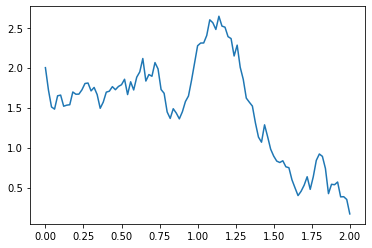

In [3]:
Y.plot_poly_process_OU(initial_state, t, T, 100)

In [4]:
order = 1
#mean = (e_n_i(order+1,order+1).transpose()).dot(Y.exp_generator_matrix_scipy(order, t=T)).dot(H_n_x(order, initial_state)).item()
mean = meanX(m, time_sequence)

order = 2
#std = (e_n_i(order+1,order+1).transpose()).dot(Y.exp_generator_matrix_scipy(order, t=T)).dot(H_n_x(order, initial_state)).item()-mean**2
#std = np.sqrt(std)
std = varX(m, b1, sigma0, time_sequence, t=0)

print('mean = ', mean)
print('std = ', std)

mean =  2.0
std =  1.4142135623730951


## PRICING

In [5]:
# Preliminary calculations for the Hermite series
# This does not depend on the strike price

N = 150 # truncation number
expG_N = lambda t: Y.exp_generator_matrix_scipy(n = N*(m+1), t=t)
#E_matrix = mE_n_matrix(N, m)
#D_matrix = mD_n_matrix(N, m)

In [6]:
H_N = np.zeros(N+1) 
H_N[0] = 1
for n in range(1,N+1):
    print('----------------- n = ', n)
    H_N_n = 0
    index_list = multi_index(m, n)
    for i in index_list:
        coeff = multi_coeff(i)
        max_power = np.max(i)
        non_zero_count = np.count_nonzero(i)
        non_zero_position = np.nonzero(i)
        vectors_list = coeff_vectors_list(i[non_zero_position], max_power)
        
        #correlator = Y.correlator_formula(max_power, non_zero_count-1, time_sequence[non_zero_position], vectors_list, initial_state)
        expG_n = lambda t: csr(expG_N(t).toarray()[:(max_power*non_zero_count+1), :(max_power*non_zero_count+1)])
        correlator = Y.correlator_formula_2(expG_n, max_power, non_zero_count-1, time_sequence[non_zero_position], vectors_list, initial_state)
        #correlator = Y.correlator_formula_3(expG_n, E_matrix[max_power-1][:non_zero_count], D_matrix[max_power-1][:non_zero_count], max_power, non_zero_count-1, time_sequence[non_zero_position], vectors_list, initial_state)
        #correlator = (e_n_i(max_power+1,max_power+1).transpose()).dot(Y.exp_generator_matrix_scipy(max_power, t=T)).dot(H_n_x(max_power, initial_state))
        H_N_n += coeff*correlator
    
    H_N[n] = H_N_n/float(((m+1)**n))

print('H_N = ', H_N)

----------------- n =  1
----------------- n =  2
----------------- n =  3
----------------- n =  4
----------------- n =  5
----------------- n =  6
----------------- n =  7
----------------- n =  8
----------------- n =  9
----------------- n =  10
----------------- n =  11
----------------- n =  12
----------------- n =  13
----------------- n =  14
----------------- n =  15
----------------- n =  16
----------------- n =  17
----------------- n =  18
----------------- n =  19
----------------- n =  20
----------------- n =  21
----------------- n =  22
----------------- n =  23
----------------- n =  24
----------------- n =  25
----------------- n =  26
----------------- n =  27
----------------- n =  28
----------------- n =  29
----------------- n =  30
----------------- n =  31
----------------- n =  32
----------------- n =  33
----------------- n =  34
----------------- n =  35
----------------- n =  36
----------------- n =  37
----------------- n =  38
----------------- n =

In [7]:
# Strike price
K = 1.0

In [8]:
# CLOSED FORMULA
price_exact = (std*norm.pdf((K-mean)/std)-(K-mean)*(1-norm.cdf((K-mean)/std)))*np.exp(-r*(T-t))
print('price_exact = ', price_exact)

price_exact =  0.8041435634300753


In [9]:
# MONTE CARLO SIMULATIONS

N_mc = 100 # number of samples
IT = 20000 # number of iterations for each sample

price_MC = np.zeros(N_mc)
time_MC = np.zeros(N_mc)
for mc in range(N_mc):
    exp = np.zeros(IT)
    a = time.time()
    for it in range(IT):
        delta = (T-t)/(m+1)
        std_BM = np.sqrt(sigma0*(np.exp(2*b1*delta)-1)/2/b1)
        Z = np.zeros(m+2)
        Z[0] = initial_state
        for k in np.arange(m+1):
            Z[k+1] = Z[k]*np.exp(b1*delta)+b0/b1*(np.exp(b1*delta)-1) + np.random.normal(loc = 0, scale =  std_BM)
            #Z[k+1] = Z[k] + (b0 + Z[k]*b1)*Delta + np.random.normal(loc = 0, scale =  np.sqrt(sigma0*Delta))
        Z = Z[1:]
        exp[it] = max(np.sum(Z)/(m+1)-K,0)*np.exp(-r*(T-t))
    price_MC[mc] = np.sum(exp)/IT
    b = time.time()
    time_MC[mc] = b-a

print('MC_price_interval = [', np.mean(price_MC) - np.std(price_MC), ', ', np.mean(price_MC) + np.std(price_MC), ']')
print('std = ', np.std(price_MC))

MC_price_interval = [ 0.798234683817006 ,  0.8084538491515474 ]
std =  0.005109582667270689


In [10]:
accuracy_MC = -np.log10(np.abs(np.mean(price_MC)-price_exact)/price_exact)
print('accuracy_MC = ', accuracy_MC)

accuracy_MC =  3.0026254366050886


### Pricing with generalized Hermite polynomials


In [11]:
# Parameters for the Hermite series 
min_scale = std/np.sqrt(2) #\underline{b}_{\sigma}
print('min_scale = ', min_scale)

drift = mean
scale = min_scale*2
ratio = (K-drift)/scale

print('K = ', K)
print('drift = ', drift)
print('scale = ', scale)
print('ratio = ', ratio)

min_scale =  1.0
K =  1.0
drift =  2.0
scale =  2.0
ratio =  -0.5


In [12]:
# We now calculate the moments of X (see Eq. (4.4))
E_N = np.zeros(N+1) 
E_N[0] = 1
for j in range(1, N+1):
    E_N_j = 0
    for i in range(j+1):
        E_N_j += float(newton(j,i))*H_N[i]*((-drift)**(j-i))
    E_N[j] = E_N_j/(scale**(j))
    
print('E_N = ', E_N)

E_N =  [ 1.00000000e+000  1.28275168e-012  5.00000000e-001 -5.21582777e-012
  7.50000000e-001 -3.57136543e-011  1.87500000e+000 -1.72235559e-010
  6.56250000e+000 -1.72633463e-009  2.95312500e+001 -1.50957931e-008
  1.62421875e+002 -1.52314897e-007  1.05574219e+003 -1.45516242e-006
  7.91806641e+003 -5.51668927e-006  6.73035644e+004  2.45675445e-004
  6.39383861e+005  7.53045082e-003  6.71353052e+006  9.36326981e-002
  7.72056012e+007 -3.80767822e-001  9.65070024e+008 -5.71523438e+001
  1.30284456e+010 -2.19969141e+003  1.88912468e+011 -6.74368750e+004
  2.92814343e+012 -1.99053200e+006  4.83143715e+013 -6.02654400e+007
  8.45501643e+014 -1.82568141e+009  1.56417842e+016 -5.44712950e+010
  3.05014895e+017 -1.63384499e+012  6.25280825e+018 -4.97182730e+013
  1.34435459e+020 -1.52868838e+015  3.02480020e+021 -4.85516847e+016
  7.10828823e+022 -1.61874692e+018  1.74153325e+024 -5.54947444e+019
  4.44091829e+025 -1.93009953e+021  1.17684625e+027 -7.04578884e+022
  3.23633937e+028 -2.801482

k =  1 , price =  0.9354940409615082
k =  2 , price =  0.8174958179395015
k =  3 , price =  0.817495817939858
k =  4 , price =  0.8064334845313276
k =  5 , price =  0.8064334845315205
k =  6 , price =  0.8045129405368568
------> Accuracy 10**(-3) for k =  6
k =  7 , price =  0.8045129405369184
k =  8 , price =  0.8041540388778436
k =  9 , price =  0.804154038877779
k =  10 , price =  0.8041052900696273
k =  11 , price =  0.8041052900694221
k =  12 , price =  0.804113139323993
k =  13 , price =  0.8041131393236276
k =  14 , price =  0.8041254850402092
k =  15 , price =  0.8041254850396627
k =  16 , price =  0.8041338773164789
k =  17 , price =  0.8041338773157352
k =  18 , price =  0.8041386290295061
k =  19 , price =  0.8041386290285611
k =  20 , price =  0.8041411207813421
k =  21 , price =  0.8041411207802077
k =  22 , price =  0.8041423758096595
k =  23 , price =  0.8041423758083606
k =  24 , price =  0.8041429929489629
k =  25 , price =  0.8041429929475209
k =  26 , price =  0.8041

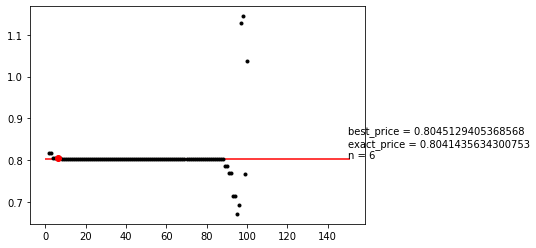

In [13]:
# We now calculate the option price via Hermite series Eq. (4.5)
# We calculate the accuracy accordingly to Eq. (5.9) 
# and we check when the series reaches the same accuracy of the MC simulations

Hprice = np.ones(N+1)*(scale*norm.pdf(ratio)+(mean-K)*(1-norm.cdf(ratio)))*np.exp(-r*(T-t))
notachieved = 1
best_n = -10
best = 0
print('k = ', 1, ', price = ', Hprice[0])
if (-np.log10(abs(price_exact-Hprice[0])/price_exact)>accuracy_MC) and notachieved:
    notachieved = 0
    best = Hprice[0]
    best_n = 1
    print('------> Accuracy 10**(-3) for k = ', 1)
    
for k in range(2,N+1):
    v_k = hermite(k).c[::-1]
    Hprice[(k-1):] += scale*norm.pdf(ratio)*(hermite(k-2)(ratio)/float(math.factorial(k))*v_k.dot(E_N[:(k+1)]))*np.exp(-r*(T-t))
    print('k = ', k, ', price = ', Hprice[k-1])
    if (np.abs(Hprice[k-1]) < 2): plt.plot(k, Hprice[k-1], 'k.')
    if (-np.log10(abs(price_exact-Hprice[k-1])/price_exact)>accuracy_MC) and notachieved:
        notachieved = 0
        best = Hprice[k-1]
        best_n = k
        print('------> Accuracy 10**(-3) for k = ', k)
    if not notachieved and (k == best_n+5):
        not_casual_bump = 1
        for j in range(best_n, k):
            not_casual_bump = not_casual_bump*(-np.log10(abs(price_exact-Hprice[j-1])/price_exact)>accuracy_MC)
        if not not_casual_bump: notachieved = 1
            
        

    
plt.hlines(y = price_exact, xmin=0, xmax = N+1, colors ='red')
s = "best_price = {} \nexact_price = {}\nn = {}"
plt.text(x = N, y = price_exact, s = s.format(best, price_exact, best_n));  
plt.plot(best_n, best, 'ro');

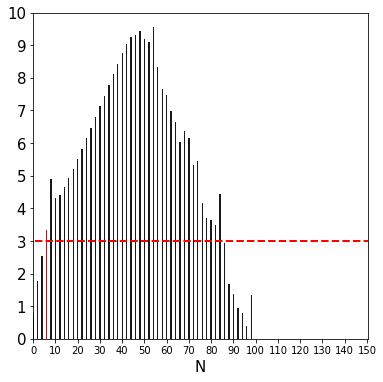

In [14]:
# Plots
range_N = np.arange(0,N+1,2)

f = plt.figure(figsize = (6,6))
ax = plt.axes()
plt.bar(range_N, -np.log10(np.abs(Hprice[range_N]-price_exact)/price_exact), alpha=0.9, color='black', width=0.6);
plt.bar(best_n, -np.log10(np.abs(Hprice[best_n]-price_exact)/price_exact), alpha=0.9, color='red', width=0.8);
plt.hlines(y = 0, xmin = 1, xmax = N+0.5,linestyle = 'solid', linewidth = 1, color='black');
plt.hlines(y = accuracy_MC, xmin = 1, xmax = N+0.5,linestyle = 'dashed', linewidth = 2, color='red');
plt.xlim([1.,N+0.5]);
plt.ylim([0, 10])
plt.xlabel('N', fontsize=15)
plt.yticks(np.arange(0,11),np.arange(0,11), fontsize=15)
plt.xticks(range_N[::5], range_N[::5], fontsize=10);
#f.savefig('Plots_OU_corr/plot_OU_corr_40_1.pdf', bbox_inches = 'tight', pad_inches = 0.01)